In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpyro as npr
import numpyro.distributions as dist
from jax import random

import seaborn as sns
import matplotlib.pyplot as plt
# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

In [2]:
# Prior
def sample_prior(n_samples):
    rng_keys = random.split(random.PRNGKey(1), 2)
    mu = npr.sample('mu', dist.Normal(0, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[0])
    sigma_sq = npr.sample('sigma_sq', dist.Gamma(1, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[1])
    theta = np.concatenate((mu, sigma_sq), axis=-1)
    return theta

In [3]:
# Load data
thetas_prior = sample_prior(n_samples=10000)
thetas_approx = np.load(f'../res/abc/laplace_approx.npy').squeeze()

mu_true, sigma_sq_true = thetas_prior[:, 0], thetas_prior[:, 1]
mu_approx, sigma_sq_approx = thetas_approx[:, 0], thetas_approx[:, 1]

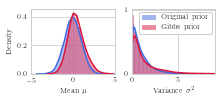

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(.55*LATEX_WIDTH, .2*LATEX_WIDTH))

sns.histplot(mu_true, ax=axs[0], label='Prior', color='royalblue', kde=True, stat='density', edgecolor="white")
sns.histplot(mu_approx, ax=axs[0], label='Gibbs prior', color='crimson', kde=True, stat='density', edgecolor="white")
axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_xlim((-5, 5))
# axs[0].legend()

sns.histplot(sigma_sq_true, stat='density', ax=axs[1], label=r'Original prior', color='royalblue', kde=True, edgecolor="white")
sns.histplot(np.clip(sigma_sq_approx, a_min=0, a_max=10), stat='density', ax=axs[1], color='crimson',
             label=r'Gibbs prior', kde=True, edgecolor="white")
# axs[1].legend()
axs[1].set_xlim([0, 9])

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')
# Ticks
axs[0].set_yticks([0, 0.2, 0.4])
axs[0].set_xticks([-5, 0, 5])
axs[1].set_yticks([0, 1])
axs[1].set_xticks([0, 5])

plt.legend(framealpha=1, frameon=True)
# plt.tight_layout()
# tikzplotlib.save('../fig/prior_vs_laplace.tex')
plt.savefig('../fig/prior_vs_laplace.pdf', bbox_inches='tight')
plt.show()

# Stochastic monotonicity

In [5]:
def position_in_sorted(t, sorted_vec):
    """Position of value t in the sorted vector sorted_list."""
    pos = 0
    for i in range(len(sorted_vec)):
        if t <= sorted_vec[i]:
            break
        else:
            pos += 1
    return pos

def get_cdf_val(t, sorted_vec):
    return position_in_sorted(t, sorted_vec) / len(sorted_vec)

In [6]:
mu_true_sorted, sigma_sq_true_sorted = np.sort(thetas_prior[:, 0]), np.sort(thetas_prior[:, 1])
mu_approx_sorted, sigma_sq_approx_sorted = np.sort(thetas_approx[:, 0]), np.sort(thetas_approx[:, 1])

ts_mu = np.linspace(-5, 5, 500)
ts_sigma_sq = np.linspace(0, 9, 500)

mu_true_cdf = [get_cdf_val(t, mu_true_sorted) for t in ts_mu]
mu_approx_cdf = [get_cdf_val(t, mu_approx_sorted) for t in ts_mu]
sigma_sq_true_cdf = [get_cdf_val(t, sigma_sq_true_sorted) for t in ts_sigma_sq]
sigma_sq_approx_cdf = [get_cdf_val(t, sigma_sq_approx_sorted) for t in ts_sigma_sq]

In [7]:
sigma_sq_maks = [sigma_sq_true_cdf[i] >= sigma_sq_approx_cdf[i] for i in range(len(ts_sigma_sq))]
t_equal_cdf = np.round(ts_sigma_sq[sigma_sq_maks][1], 2)
t_val_equal_cdf = np.round(np.array(sigma_sq_true_cdf)[sigma_sq_maks][1], 2)
print(f'The cdfs for the variance coincide at t={np.round(t_equal_cdf, 2)} with a value of F(t)={np.round(t_val_equal_cdf, 2)}')

The cdfs for the variance coincide at t=0.02 with a value of F(t)=0.02


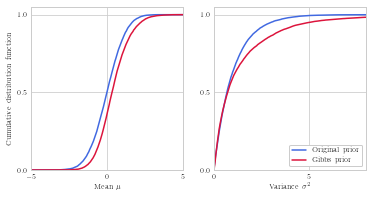

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(LATEX_WIDTH, .5*LATEX_WIDTH))

# Means cdf
axs[0].plot(ts_mu, mu_true_cdf, label='Original prior', color='royalblue')
axs[0].plot(ts_mu, mu_approx_cdf, label='Gibbs prior', color='crimson')

axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_ylabel(r'Cumulative distribution function')

# Variances cdf
axs[1].plot(ts_sigma_sq, sigma_sq_true_cdf, label='Original prior', color='royalblue')
axs[1].plot(ts_sigma_sq, sigma_sq_approx_cdf, label='Gibbs prior', color='crimson')

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')

axs[0].set_xlim((-5, 5))
axs[1].set_xlim((0, 8))
axs[0].set_ylim((0, 1.05))
axs[1].set_ylim((0, 1.05))

axs[0].set_yticks([0, .5, 1])
axs[0].set_xticks([-5, 0, 5])
axs[1].set_yticks([0, .5, 1])
axs[1].set_xticks([0, 5])

plt.legend(framealpha=1, frameon=True, loc='lower right')
# plt.tight_layout()
# tikzplotlib.save('../fig/prior_vs_laplace_cdf.tex')
plt.savefig('../fig/prior_vs_laplace_cdf.pdf', bbox_inches='tight')
plt.show()